# Autonomous Yield Estimator

In [1]:
#This is the online version Jupyter File


def check_if_coors_in_grey_area(passed_df):
    grey_coors_df = passed_df['centerX'] < 1000
    
    loc_indx_vlu = []
    for i in range(len(grey_coors_df)):
        if grey_coors_df[i] == False:
            loc_indx_vlu.append(i)
    #loc_indx_vlu
    #IMPLEMENT THE REMOVAL OF UNWANTED ROWS WITH, loc_indx_vlu
    for i in loc_indx_vlu:
        passed_df = passed_df.drop(i)
    return_reduced_df = passed_df.reset_index(drop=True)
    return return_reduced_df


def predict_next_coors(df_previous_coors, momentum_X = -18.585, momentum_Y = +8.685):
    #momentum_X = -18.585
    #momentum_Y = +8.685
    new_data = {'centerX': df_previous_coors['centerX'] + momentum_X, 
                'centerY': df_previous_coors['centerY'] + momentum_Y}
    
    new_predicted_coors = pd.DataFrame(new_data)
    
    return new_predicted_coors


def check_if_coors_predicted(dataframe_current_coors, dataframe_previous_coors, momentum_X = -18.585, momentum_Y = +8.685):
    cnt = 0
    momentum_X = -18.585
    momentum_Y = +8.685
    momentum_tot = abs(momentum_X)+abs(momentum_Y) 
    # 2.55 is decent, got 137 out of 105
    offset_momentum = 3.7
    for i in range(len(dataframe_current_coors)):
        temp_x_diff = dataframe_previous_coors['centerX'] - dataframe_current_coors.iloc[i][0]
        temp_y_diff = dataframe_previous_coors['centerY'] - dataframe_current_coors.iloc[i][1]
        temp_xy_diff = temp_x_diff.abs() + temp_y_diff.abs()
        bool_temp_xy_diff = temp_xy_diff < round(momentum_tot*offset_momentum, 2)
        if bool_temp_xy_diff.any():
            #This checks if any value is true in bool, and if it was,
            #then it was predicted previously, therefore don't count in running total
            cnt+=1
    amount_predicted = cnt
    return amount_predicted


def merge_two_dataframes(df1, df2):
    combined_df = pd.concat([df1, df2], axis=0)
    combined_df = combined_df.reset_index(drop=True) 
    return combined_df


def remove_out_of_frame_coors(passed_df, np_array, momentum_X = -18.585):
    #momentum_X = -18.585
    #momentum_Y = +8.685
    
    loc_indx_vlu = []
    filter1 = passed_df['centerX'] < -abs(momentum_X*2)
    for i in range(len(passed_df)):
            if filter1[i] == True:
                loc_indx_vlu.append(i)
    loc_indx_vlu
    
    #loc_indx_vlu
    #IMPLEMENT THE REMOVAL OF UNWANTED ROWS WITH, loc_indx_vlu
    for i in loc_indx_vlu:
        passed_df = passed_df.drop(i)
    return_reduced_df = passed_df.reset_index(drop=True)
    return_reduced_np = np.delete(np_array,loc_indx_vlu, axis = 0)
    #print(loc_indx_vlu)
    #print(type(loc_indx_vlu))
    return return_reduced_df, return_reduced_np


# example call
# blob_shrink(x_in, y_pred, avg_blob_center)
def blob_shrink(input_df, y_pred_vlus, blob_centers):
    temp_in_df = input_df.copy()
    for indx, item in enumerate(y_pred_vlus):
        vlu_update = blob_centers[item] - temp_in_df[indx]
        vlu_update = vlu_update / 5 # Origianlly value of 4
        vlu_update = vlu_update.round(3)
        vlu_update
        temp_in_df[indx] = temp_in_df[indx] + vlu_update
    return temp_in_df


def momentum_update_center_vlu(fitted_model, box_centers, blob_centers):
    center_box_predict = fitted_model.predict(box_centers)
    
    avg_center_diff = []
    for indx, item in enumerate(center_box_predict):
        diff = box_centers[indx] - blob_centers[item]
        avg_center_diff.append(diff.tolist())
    avg_center_diff = np.array(avg_center_diff)
    xy_avg_mom = np.average(avg_center_diff, axis = 0)
    return xy_avg_mom


def k_means_gaussian(passed_pred_next_coors, num_components):
    from sklearn.mixture import GaussianMixture
    import matplotlib.pyplot as plt
    from scipy import stats
    
    x_in = passed_pred_next_coors.to_numpy()
    y_pred = GaussianMixture(n_components=num_components, random_state=42).fit(x_in).predict(x_in)
    
    mapping = {}
    for class_id in np.unique(y_pred):
        mode, _ = stats.mode(y_pred[y_pred==class_id])
        mapping[mode[0]] = class_id
        
    y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])
    return y_pred


Silhouette Score for k = 2: 0.710
Silhouette Score for k = 3: 0.727
Silhouette Score for k = 4: 0.828
Silhouette Score for k = 5: 0.856
Silhouette Score for k = 6: 0.835
Silhouette Score for k = 7: 0.821
Silhouette Score for k = 8: 0.743
Silhouette Score for k = 9: 0.637
Silhouette Score for k = 10: 0.617
Silhouette Score for k = 11: 0.565
Silhouette Score for k = 12: 0.498


The calculated K value: 5
Chosen K Value        : 5


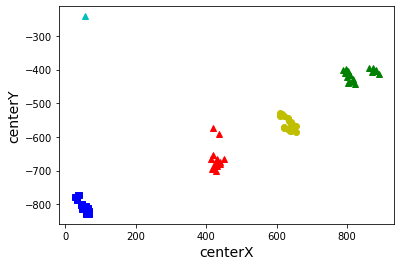

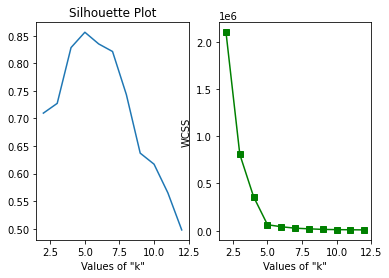

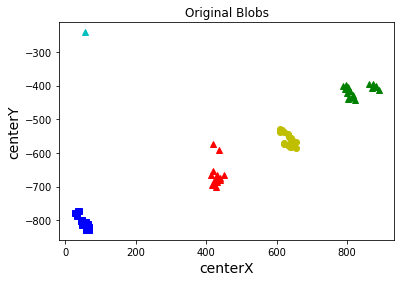

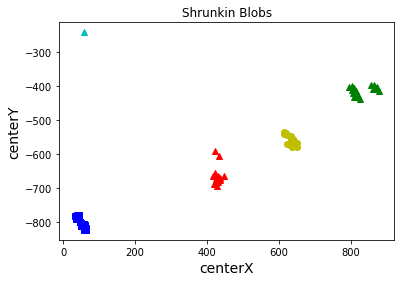



Previous momentum value: [-16.68414286   7.32857143]
New momentum value     : [-16.62657143   7.289     ]


In [5]:

import numpy as np
import pandas as pd
import time
import cv2
import imutils
from imutils.video import FPS
from imutils.video import VideoStream

from IPython.display import clear_output

from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from scipy import stats

#INPUT_FILE='20210829_155900.mp4'
INPUT_FILE='snippet_02.mp4'
#INPUT_FILE='snippet_01.mp4'
OUTPUT_FILE='output.avi'
LABELS_FILE='data/obj.names'
CONFIG_FILE='cfg/yolo-obj.cfg'
WEIGHTS_FILE='yolo-obj_last.weights'
CONFIDENCE_THRESHOLD=0.05

H=None
W=None

fps = FPS().start()

#Orig_Width = 1920
Orig_Width = 1080
Desired_Width = 1080
divider = Desired_Width / Orig_Width 
#new_height = int(1080 * divider)
new_height = int(1920 * divider)

frame_width = Desired_Width # originally was 800, video is 1920
frame_height = new_height # originally was 600, video is 1080

fourcc = cv2.VideoWriter_fourcc(*"MJPG")
writer = cv2.VideoWriter(OUTPUT_FILE, fourcc, 30,
                         (frame_width, frame_height), True)

LABELS = open(LABELS_FILE).read().strip().split("\n")

np.random.seed(4)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
                           dtype="uint8")


net = cv2.dnn.readNetFromDarknet(CONFIG_FILE, WEIGHTS_FILE)

vs = cv2.VideoCapture(INPUT_FILE)


# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
cnt =0;

#font = cv2.FONT_HERSHEY_PLAIN
putText_font = cv2.FONT_HERSHEY_SIMPLEX
putText_orig_cord = (10,50)#200,50
putText_fontScale = 2
putText_fontColor = (0,0,139) #In format of BGR(blue,green,red), not RGB
putText_lineType = 5

# Initialize Values
number_of_clusters = 0
first_cluster_seen = 0
pre_removal_cur_coors_df = pd.DataFrame([],columns = ['centerX','centerY'])
new_box_seen = 0
clusters_in_frame = 0

#988, 402
#780, 493
#412, 641
#421, 643
estimate_coordinate_test_X = 988
estimate_coordinate_test_Y = 402
start_momentum = [-18.585, +8.685]
momentum_xy = [-18.585, +8.685]

#60
#689
#824
# Length of 944 (at least 944)
for ii in range(944):
    cnt+=1
    #print ("Frame number", cnt)
    try:
        (grabbed, image) = vs.read()
    except:
        break
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),
        swapRB=True, crop=False)
    net.setInput(blob)
    if W is None or H is None:
        (H, W) = image.shape[:2]
    layerOutputs = net.forward(ln)

    # initialize our lists of detected bounding boxes, confidences, and
    # class IDs, respectively
    boxes = []
    confidences = []
    classIDs = []

    frame_coors = []
    list_to_save_center_values = []
    # loop over each of the layer outputs
    for output in layerOutputs:
        # loop over each of the detections
        for detection in output:
            # extract the class ID and confidence (i.e., probability) of
            # the current object detection
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            # filter out weak predictions by ensuring the detected
            # probability is greater than the minimum probability
            if confidence > CONFIDENCE_THRESHOLD:
                # scale the bounding box coordinates back relative to the
                # size of the image, keeping in mind that YOLO actually
                # returns the center (x, y)-coordinates of the bounding
                # box followed by the boxes' width and height
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                # use the center (x, y)-coordinates to derive the top and
                # and left corner of the bounding box
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                # update our list of bounding box coordinates, confidences,
                # and class IDs
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

                temp_list = [centerX, centerY]
                #list_to_save_center_values.append([temp_list, cnt])
                list_to_save_center_values.append(temp_list)

    # apply non-maxima suppression to suppress weak, overlapping bounding
    # boxes
    NMS_Threshold_Box_Overlap = .5
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, CONFIDENCE_THRESHOLD,
                            NMS_Threshold_Box_Overlap)

    # ensure at least one detection exists
    if len(idxs) > 0:
        # loop over the indexes we are keeping
        for i in idxs.flatten():
            # extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            color = [int(c) for c in COLORS[classIDs[i]]]

            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
            cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                0.5, color, 2)
    ### Text over image
    temp_text = "Frame number :" + str(cnt)
    putText_orig_cord = (10,1500)
    cv2.putText(image,temp_text,putText_orig_cord, 
                putText_font,putText_fontScale,putText_fontColor,
                putText_lineType)
    ########
    ######## Beginning of cluster count
    ########
    idxs = idxs.reshape((-1))
    idxs
    keep_center_values = []
    for i in idxs:
        keep_center_values.append(list_to_save_center_values[i])
    keep_center_values
    #print(list_to_save_center_values)
    #print(keep_center_values)
    cur_coors_df = pd.DataFrame(keep_center_values,
                       columns = ['centerX','centerY'])
    
    if first_cluster_seen >= 1:
        pre_removal_cur_coors_df = cur_coors_df.copy()
    
    #Remove Coordinates in gray area, this is so that a full grape cluster can enter the frame
    #Orig_Width
    cur_coors_df = check_if_coors_in_grey_area(cur_coors_df)
    
    if len(cur_coors_df) > 0:
        first_cluster_seen +=1
    # This checks if/else the first time grape cluster is detected
    if first_cluster_seen != 1:
        #call save predict function
        num_coordinates_pred = check_if_coors_predicted(cur_coors_df, pred_next_coors_df, momentum_xy[0], momentum_xy[1])
        merged_cur_pred_df = merge_two_dataframes(cur_coors_df, pred_next_coors_df)
        
        pred_next_coors_df = predict_next_coors(merged_cur_pred_df, momentum_xy[0], momentum_xy[1]).copy()
        #Save/update frame cluster count, different then total cluster count
        if (len(cur_coors_df) >= num_coordinates_pred) and ((len(cur_coors_df) - num_coordinates_pred) >= 0):
            
            diff_pred = len(cur_coors_df) - num_coordinates_pred
            number_of_clusters += diff_pred
            
            clusters_in_frame = len(np.unique(y_pred_classes)) + diff_pred
            y_pred_classes = k_means_gaussian(pred_next_coors_df, clusters_in_frame)
            
        else:
            #number_of_clusters = number_of_clusters 
            print("Didn't expect this, predicted more coordinates then currently available.")
            print('Need to find this location, and further troubleshoot.')
            pass
        
        
        #Now remove any predicted coordinates that are out of frame
        pred_next_coors_df, y_pred_classes = remove_out_of_frame_coors(pred_next_coors_df, y_pred_classes, momentum_xy[0])
        #print(len(np.unique(y_pred_classes)))

        #This should place x's where predicted next cluster
        for i in range(len(pred_next_coors_df)):
            temp_a = int(pred_next_coors_df.loc[i][0])
            temp_b = int(pred_next_coors_df.loc[i][1])
            putText_orig_cord = (temp_a, temp_b)

            cv2.putText(image,'x', 
                putText_orig_cord, 
                putText_font, 
                putText_fontScale,
                putText_fontColor,
                putText_lineType)
        
    else:
        prev_coors_df = cur_coors_df.copy()
        pred_next_coors_df = predict_next_coors(prev_coors_df)
        number_of_clusters = len(cur_coors_df)
        clusters_in_frame = len(cur_coors_df)
        #new_box_seen = 0
        y_pred_classes = k_means_gaussian(pred_next_coors_df, clusters_in_frame)
    
    if first_cluster_seen >= 1:
        prev_coors_df = prev_coors_df.append(pre_removal_cur_coors_df)
    
    
    ####
    ####
    ####
    ### Inserting Momentum and center points
    ####
    ####
    ####
    
    
    
    ####
    ####
    ####
    #### Update more image information
    ####
    ####
    ####
    
    #cv2.putText(image)
    putText_orig_cord = (10,1600)
    cv2.putText(image,"Running Cluster Count :" +str(number_of_clusters),
                putText_orig_cord, 
                putText_font,putText_fontScale,putText_fontColor,
                putText_lineType)
    #cv2.putText(image,"Running Cluster Count :" +str(10),(200,50),font,2,(255,255,255),1)
    
    putText_white = (255, 255, 255)
    putText_thickness = 2
    putText_scale = 2
    #cv2.FONT_HERSHEY_PLAIN
    #cv2.FONT_HERSHEY_TRIPLEX
    #cv2.FONT_HERSHEY_DUPLEX
    
    #cv2.putText(image, org=(150, y), cv2.FONT_HERSHEY_SCRIPT_COMPLEX, 
    #fontScale=4, color=(255,255,0), thickness
    putText_orig_cord = (10,50)
    cv2.putText(image,"Starting Momentum :" +str(start_momentum),
                putText_orig_cord, 
                cv2.FONT_HERSHEY_PLAIN,putText_scale,putText_white,
                putText_thickness)
    
    putText_orig_cord = (10,150)
    cv2.putText(image,"Current  Momentum :" +str(momentum_xy),
                putText_orig_cord, 
                cv2.FONT_HERSHEY_PLAIN,putText_scale,putText_white,
                putText_thickness)
    
    """putText_orig_cord = (10,1700)
    cv2.putText(image,"Cluster Frame Count :" +str(clusters_in_frame),
                putText_orig_cord, 
                putText_font,putText_fontScale,putText_fontColor,
                putText_lineType)
    
    putText_orig_cord = (10,1800)
    cv2.putText(image,"Boxes Highlighted :" +str(len(keep_center_values)),
                putText_orig_cord, 
                putText_font,putText_fontScale,putText_fontColor,
                putText_lineType)"""

    #[988, 402] = (X - 18.75), (Y + 8.75)
    #[780, 493] = (X - 18.42), (Y + 8.75)
    #[412, 641] = (X - 18.42), (Y + 8.62)
    #[421, 643] = (X - 18.75), (Y + 8.62)
    # Averages = -18.585, +8.685
    if cnt!=1:
        # 13.13 and 10.01 manually calculated momentum change per pixle in x and y direction
        estimate_coordinate_test_X = estimate_coordinate_test_X - 18.585
        estimate_coordinate_test_Y = estimate_coordinate_test_Y + 8.685
    putText_orig_cord = (round(estimate_coordinate_test_X), 
                         round(estimate_coordinate_test_Y))
    cv2.putText(image,'x', 
                putText_orig_cord, 
                putText_font, 
                putText_fontScale,
                putText_fontColor,
                putText_lineType)

    start_point = (1000, 0)
    end_point = (1000, 1900)
    # Green color in BGR
    color = (0, 255, 0)
    # Line thickness of 9 px
    thickness = 9
    cv2.line(image, start_point, end_point, color, thickness)
    
    #Use this commented code, to test pixel locations on image
    #putText_orig_cord = (300, 300)
    #cv2.putText(image,'x', 
        #putText_orig_cord, 
        #putText_font, 
        #putText_fontScale,
        #putText_fontColor,
        #putText_lineType)
    
    if cnt == 6:
        putText_fontColor = (139,0,0) #In format of BGR(blue,green,red), not RGB
    # show the output image
    cv2.imshow("output", cv2.resize(image,(frame_width, frame_height)))

    writer.write(cv2.resize(image,(frame_width, frame_height)))
    fps.update()
    key = cv2.waitKey(1) & 0xFF
    time.sleep(0.07)
    #time.sleep(1.5)
    if cnt == 1:
        time.sleep(2)
    if key == ord("q"):
        break
    #168, 221, 
    
    if (ii%10 == 0) & (first_cluster_seen > 9):
        # importing the libraries
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        from sklearn.cluster import KMeans
        from sklearn.metrics import silhouette_score

        temp_df_to_numpy = pred_next_coors_df.to_numpy()
        x_in = temp_df_to_numpy

        #x_in_df = pd.DataFrame(x_in)
        dataset = pd.DataFrame(x_in)

        #print(dataset.shape)


        # determining the maximum number of clusters
        # using the simple method
        limit = int((dataset.shape[0]//2)**0.5)*2

        # determining number of clusters
        # using silhouette score method
        tmp_x = []
        tmp_y = []
        for k in range(2, limit+1):
            model = KMeans(n_clusters=k)
            model.fit(dataset)
            pred = model.predict(dataset)
            score = silhouette_score(dataset, pred)
            print('Silhouette Score for k = {}: {:<.3f}'.format(k, score))
            tmp_x.append(k)
            tmp_y.append(score)

        max_index_loc = pd.DataFrame(tmp_y).idxmax()[0]
        kk = tmp_x[max_index_loc]
        print('\n')
        print('The calculated K value: ' + str(kk))
        
        kk = int((kk + len(keep_center_values)) /2)
        print('Chosen K Value        : ' + str(kk))
        
        putText_red = (0,0,255)
        putText_orig_cord = (10,500)
        cv2.putText(image,"K-Means :" +str(kk),
                    putText_orig_cord, 
                    cv2.FONT_HERSHEY_PLAIN,putText_scale,putText_red,
                    putText_thickness)

        # Testing Elbow Method
        import numpy as np
        import pandas as pd
        import matplotlib.pyplot as plt
        from sklearn.cluster import KMeans

        #x_in_df = pd.DataFrame(x_in)
        #dataset = pd.DataFrame(x_in)

        # determining the maximum number of clusters
        # using the simple method
        limit = int((dataset.shape[0]//2)**0.5)*2

        # selecting optimal value of 'k'
        # using elbow method

        # wcss - within cluster sum of
        # squared distances
        wcss = {}

        for k in range(2,limit+1):
            model = KMeans(n_clusters=k)
            model.fit(dataset)
            wcss[k] = model.inertia_





        #Just plot Pandas Dataframe on it's own Graph:

        from sklearn.mixture import GaussianMixture
        import matplotlib.pyplot as plt

        fit_model = GaussianMixture(n_components=kk, random_state=42).fit(x_in)
        y_pred = fit_model.predict(x_in)

        from scipy import stats

        mapping = {}
        for class_id in np.unique(y_pred):
            mode, _ = stats.mode(y_pred[y_pred==class_id])
            mapping[mode[0]] = class_id

        y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

        #Invert to mimic image plot
        temp_x_in = x_in * [1,-1]

        plt.plot(temp_x_in[y_pred==0, 0], temp_x_in[y_pred==0, 1], "yo", label="Cluster 1")
        plt.plot(temp_x_in[y_pred==1, 0], temp_x_in[y_pred==1, 1], "bs", label="Cluster 2")
        plt.plot(temp_x_in[y_pred==2, 0], temp_x_in[y_pred==2, 1], "g^", label="Cluster 3")
        plt.plot(temp_x_in[y_pred==3, 0], temp_x_in[y_pred==3, 1], "r^", label="Cluster 4")
        plt.plot(temp_x_in[y_pred==4, 0], temp_x_in[y_pred==4, 1], "c^", label="Cluster 5")
        plt.plot(temp_x_in[y_pred==5, 0], temp_x_in[y_pred==5, 1], "k^", label="Cluster 6")

        plt.xlabel("centerX", fontsize=14)
        plt.ylabel("centerY", fontsize=14)
        #plt.legend(loc="lower right", fontsize=12)
        #plt.figure(figsize=(6,6))
        plt.show()

        # plotting silhouette values
        plt.subplot(1,2,1)
        plt.plot(tmp_x, tmp_y)
        plt.title('Silhouette Plot')
        plt.xlabel('Values of "k"')
        #plt.ylabel('y-axis')

        # plotting the wcss values to find out the elbow value
        plt.subplot(1,2,2)
        plt.plot(wcss.keys(), wcss.values(), 'gs-')
        plt.xlabel('Values of "k"')
        plt.ylabel('WCSS')
        plt.show()


        ########
        ########
        ########


        """from sklearn.mixture import GaussianMixture
        import matplotlib.pyplot as plt

        y_pred = GaussianMixture(n_components=kk, random_state=42).fit(x_in).predict(x_in)

        from scipy import stats

        mapping = {}
        for class_id in np.unique(y_pred):
            mode, _ = stats.mode(y_pred[y_pred==class_id])
            mapping[mode[0]] = class_id

        y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])"""


        ###
        #### Printing Image
        ###

        blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),
            swapRB=True, crop=False)



        NMS_Threshold_Box_Overlap = .5
        idxs = cv2.dnn.NMSBoxes(boxes, confidences, CONFIDENCE_THRESHOLD,
                                NMS_Threshold_Box_Overlap)

        # ensure at least one detection exists
        if len(idxs) > 0:
            # loop over the indexes we are keeping
            for i in idxs.flatten():
                # extract the bounding box coordinates
                (x, y) = (boxes[i][0], boxes[i][1])
                (w, h) = (boxes[i][2], boxes[i][3])

                color = [int(c) for c in COLORS[classIDs[i]]]

                cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
                text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
                cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, color, 2)
        ### Text over image
        temp_text = "Frame number :" + str(cnt)
        putText_orig_cord = (10,1500)
        cv2.putText(image,temp_text,putText_orig_cord, 
                    putText_font,putText_fontScale,putText_fontColor,
                    putText_lineType)


        #This should place x's where predicted next cluster
        for i in range(len(pred_next_coors_df)):
            temp_a = int(pred_next_coors_df.loc[i][0])
            temp_b = int(pred_next_coors_df.loc[i][1])
            putText_orig_cord = (temp_a, temp_b)

            cv2.putText(image,'x', 
                putText_orig_cord, 
                putText_font, 
                putText_fontScale,
                putText_fontColor,
                putText_lineType)

        putText_orig_cord = (10,1600)
        cv2.putText(image,"Running Cluster Count :" +str(number_of_clusters),
                    putText_orig_cord, 
                    putText_font,putText_fontScale,putText_fontColor,
                    putText_lineType)


        start_point = (1000, 0)
        end_point = (1000, 1900)
        # Green color in BGR
        color = (0, 255, 0)
        # Line thickness of 9 px
        thickness = 5
        cv2.line(image, start_point, end_point, color, thickness)

        avg_blob_center = []
        for i in range(len(np.unique(y_pred))):
            putText_orig_cord = [int(np.average(x_in[y_pred==i, 0])), 
                                 int(np.average(x_in[y_pred==i, 1]))]
            avg_blob_center.append(putText_orig_cord)
            center_fontColor = (0,139,139) #In format of BGR(blue,green,red), not RGB
            center_fontScale = 1
            #Update for Centroid Venter Values
            cv2.putText(image,'o', 
                        putText_orig_cord, 
                        putText_font, 
                        center_fontScale,
                        center_fontColor,
                        putText_lineType)

        avg_blob_center = np.array(avg_blob_center)


        #Print Center Box Values
        keep_center_values
        for i in range(len(keep_center_values)):
            putText_orig_cord = keep_center_values[i]
            center_fontColor = (0,0,139) #In format of BGR(blue,green,red), not RGB
            center_fontScale = 1
            #Update for Centroid Venter Values
            cv2.putText(image,'o', 
                        putText_orig_cord, 
                        putText_font, 
                        center_fontScale,
                        center_fontColor,
                        putText_lineType)

        # show the output image
        cv2.imshow("output", cv2.resize(image,(frame_width, frame_height)))

        writer.write(cv2.resize(image,(frame_width, frame_height)))
        fps.update()
        key = cv2.waitKey(1) & 0xFF



        ########
        ########
        ########

        temp_x_in = x_in * [1,-1]

        #plt.subplot(1,2,1)
        plt.plot(temp_x_in[y_pred==0, 0], temp_x_in[y_pred==0, 1], "yo", label="Cluster 1")
        plt.plot(temp_x_in[y_pred==1, 0], temp_x_in[y_pred==1, 1], "bs", label="Cluster 2")
        plt.plot(temp_x_in[y_pred==2, 0], temp_x_in[y_pred==2, 1], "g^", label="Cluster 3")
        plt.plot(temp_x_in[y_pred==3, 0], temp_x_in[y_pred==3, 1], "r^", label="Cluster 4")
        plt.plot(temp_x_in[y_pred==4, 0], temp_x_in[y_pred==4, 1], "c^", label="Cluster 5")
        plt.plot(temp_x_in[y_pred==5, 0], temp_x_in[y_pred==5, 1], "k^", label="Cluster 6")

        plt.title('Original Blobs')
        plt.xlabel("centerX", fontsize=14)
        plt.ylabel("centerY", fontsize=14)
        #plt.legend(loc="lower right", fontsize=12)
        plt.show()


        #plt.subplot(1,2,2)
        temp_x_in_02 = blob_shrink(x_in, y_pred, avg_blob_center)
        temp_x_in = temp_x_in_02 * [1,-1]

        plt.plot(temp_x_in[y_pred==0, 0], temp_x_in[y_pred==0, 1], "yo", label="Cluster 1")
        plt.plot(temp_x_in[y_pred==1, 0], temp_x_in[y_pred==1, 1], "bs", label="Cluster 2")
        plt.plot(temp_x_in[y_pred==2, 0], temp_x_in[y_pred==2, 1], "g^", label="Cluster 3")
        plt.plot(temp_x_in[y_pred==3, 0], temp_x_in[y_pred==3, 1], "r^", label="Cluster 4")
        plt.plot(temp_x_in[y_pred==4, 0], temp_x_in[y_pred==4, 1], "c^", label="Cluster 5")
        plt.plot(temp_x_in[y_pred==5, 0], temp_x_in[y_pred==5, 1], "k^", label="Cluster 6")

        plt.title('Shrunkin Blobs')
        plt.xlabel("centerX", fontsize=14)
        plt.ylabel("centerY", fontsize=14)
        #plt.legend(loc="lower right", fontsize=12)
        plt.show()


        ########
        ########
        ########
        #momentum_xy = momentum_xy
        print('\n')
        print('Previous momentum value: ' + str(momentum_xy))

        temp_keep_center_values =[]
        for i in range(len(keep_center_values)):
            if keep_center_values[i][0] < 1000:
                temp_keep_center_values.append(keep_center_values[i])
        #print(temp_keep_center_values)
        
        fit_model = GaussianMixture(n_components=kk, random_state=42).fit(x_in)
        temp = momentum_update_center_vlu(fit_model, temp_keep_center_values, avg_blob_center )
        #temp/10
        temp = np.array(temp)
        momentum_xy = np.array(momentum_xy)

        momentum_xy = momentum_xy + (temp/30)
        momentum_xy = [round(momentum_xy[0], 4), round(momentum_xy[1], 4)]
        
        momentum_xy = np.array(start_momentum) + np.array(momentum_xy)
        momentum_xy = momentum_xy/2.1

        print('New momentum value     : ' + str(momentum_xy))
        
        
        yy_pred = GaussianMixture(n_components=kk, random_state=42).fit(pred_next_coors_df.to_numpy()).predict(pred_next_coors_df.to_numpy())
        shrunk = blob_shrink(pred_next_coors_df.to_numpy(), yy_pred, avg_blob_center)
        pred_next_coors_df = pd.DataFrame(shrunk, columns=['centerX', 'centerY'])
        
        time.sleep(.3)
        clear_output(wait=True)



In [6]:
fps.stop()

print("[INFO] elasped time: {:.2f}".format(fps.elapsed()))
print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))

# do a bit of cleanup
cv2.destroyAllWindows()

# release the file pointers
print("[INFO] cleaning up...")
writer.release()
vs.release()

[INFO] elasped time: 18.60
[INFO] approx. FPS: 1.72
[INFO] cleaning up...
